# An Analysis of Pakistani Homes

## Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sklearn.linear_model as linMod
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
import sklearn.tree as tree
from sklearn.tree import DecisionTreeRegressor

from scipy import stats

UP_DIR = "/kaggle/input/pakistan-house-price-prediction"

# Open data
csvPath = os.path.join(UP_DIR, 'Entities.csv')
housesRaw = pd.read_csv(csvPath)

## Clean up data

In [2]:
# Copy and filter housesRaw and print
housesClean = housesRaw[['property_type', 'purpose', 'bedrooms',
                        'baths', 'Total_Area', 'city', 'province_name',
                         'latitude', 'longitude', 'price']].rename(
    columns={'Total_Area': 'area', 'property_type': 'type', 'province_name': 'province'})

housesClean = housesClean[housesClean.baths != 0]
housesClean = housesClean[housesClean.bedrooms != 0]
housesClean = housesClean[housesClean.area != 0]
housesClean = housesClean[housesClean.purpose == 'For Sale']

housesClean = housesClean.drop(['purpose'], axis=1)

# Remove Outliers
housesClean = housesClean[(
    np.abs(stats.zscore(housesClean['area'])) < 3)]
housesClean = housesClean[(
    np.abs(stats.zscore(housesClean['bedrooms'])) < 3)]
housesClean = housesClean[(
    np.abs(stats.zscore(housesClean['baths'])) < 3)]
housesClean = housesClean[(
    np.abs(stats.zscore(housesClean['price'])) < 3)]

colors = {'Karachi': 'red', 'Lahore': 'blue', 'Islamabad': 'green',
          'Faisalabad': 'yellow', 'Rawalpindi': 'purple'}

print(housesClean)

         type  bedrooms  baths       area       city           province  \
0        Flat         2      2   1089.004  Islamabad  Islamabad Capital   
1        Flat         3      3  15246.056  Islamabad  Islamabad Capital   
2       House         5      6   2178.008  Islamabad  Islamabad Capital   
3       House         4      4  10890.000  Islamabad  Islamabad Capital   
4       House         3      3   2178.008  Islamabad  Islamabad Capital   
...       ...       ...    ...        ...        ...                ...   
168436  House         3      4   2178.008    Karachi              Sindh   
168437  House         3      4   1361.255    Karachi              Sindh   
168438  House         3      3   2178.008    Karachi              Sindh   
168439  House         4      4   3811.514    Karachi              Sindh   
168445  House         3      3  25591.594    Karachi              Sindh   

         latitude  longitude     price  
0       33.679890  73.012640  10000000  
1       33.700993

## Visualize data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


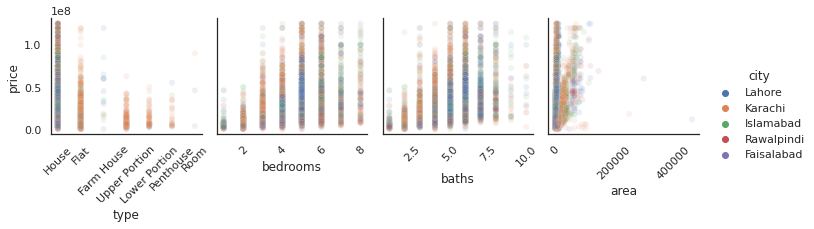

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


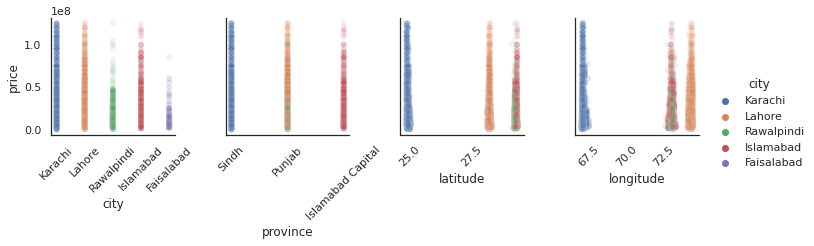

In [3]:
# Pairplot (divided into 2 for easy viewing)
sns.set(style='white', font_scale=1, color_codes=True)

maxPrice = housesClean['price'].max()
upperY = maxPrice*1.25


pair = sns.pairplot(housesClean.sample(10000),
                    plot_kws={'alpha': 0.1},
                    x_vars=['type', 'bedrooms', 'baths', 'area'],
                    y_vars=['price'],
                    hue='city')
for axis in pair.fig.axes:
    axis.set_xticklabels(axis.get_xticklabels(), rotation=45)
plt.show()

pair = sns.pairplot(housesClean.sample(10000),
                    plot_kws={'alpha': 0.1},
                    x_vars=['city', 'province', 'latitude', 'longitude'],
                    y_vars=['price'],
                    hue='city')
for axis in pair.fig.axes:
    axis.set_xticklabels(axis.get_xticklabels(), rotation=45)
plt.show()

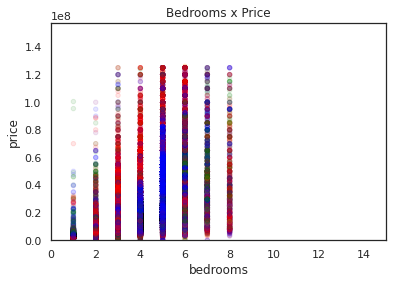

In [4]:
# Bedrooms x Price
housesClean.plot(x='bedrooms',
                 y='price',
                 kind='scatter',
                 alpha=.1,
                 c=housesClean['city'].map(colors))
plt.xlim([0, 15])
plt.ylim([0, upperY])
plt.title('Bedrooms x Price')
plt.show()

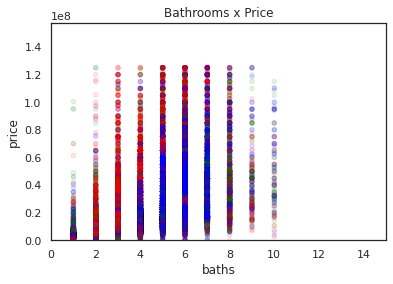

In [5]:
# Bathrooms x Price
housesClean.plot(x='baths',
                 y='price',
                 kind='scatter',
                 alpha=.1,
                 c=housesClean['city'].map(colors))
plt.xlim([0, 15])
plt.ylim([0, upperY])
plt.title('Bathrooms x Price')
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


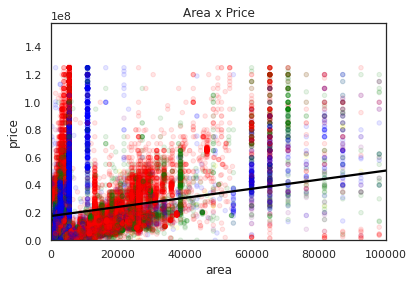

In [6]:
# Area x Price
housesClean.plot(x='area',
                 y='price',
                 kind='scatter',
                 alpha=.1,
                 c=housesClean['city'].map(colors))
plt.xlim([0, 100000])
plt.ylim([0, upperY])
sns.regplot(housesClean.area, housesClean.price, order=1,
            ci=None, scatter=False, color='black')
plt.title('Area x Price')
plt.show()

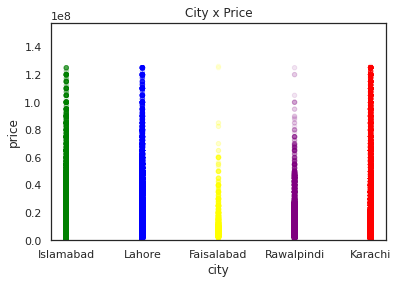

In [7]:
# City x Price
housesClean.plot(x='city',
                 y='price',
                 kind='scatter',
                 alpha=.1,
                 c=housesClean['city'].map(colors))
plt.ylim([0, upperY])
plt.title('City x Price')
plt.show()

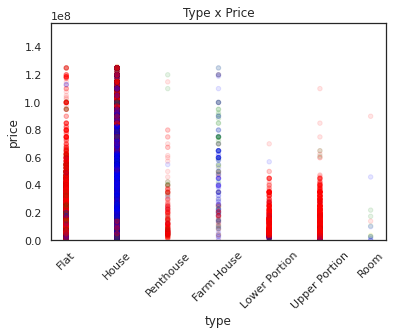

In [8]:
# Type x Price
housesClean.plot(x='type',
                 y='price',
                 kind='scatter',
                 alpha=.1,
                 c=housesClean['city'].map(colors))
plt.ylim([0, upperY])
plt.title('Type x Price')
plt.xticks(rotation=45)
plt.show()

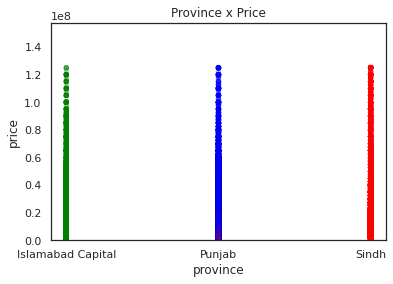

In [9]:
# Province x Price
housesClean.plot(x='province',
                 y='price',
                 kind='scatter',
                 alpha=.1,
                 c=housesClean['city'].map(colors))
plt.ylim([0, upperY])
plt.title('Province x Price')
plt.show()

In [10]:
housesClean = pd.get_dummies(
    data=housesClean, drop_first=True).rename(
    columns={'type_Lower Portion': 'type_Lower_Portion',
             'type_Upper Portion': 'type_Upper_Portion',
             'purpose_For Sale': 'purpose_For_Sale'})

print(housesClean)

        bedrooms  baths       area   latitude  longitude     price  type_Flat  \
0              2      2   1089.004  33.679890  73.012640  10000000          1   
1              3      3  15246.056  33.700993  72.971492   6900000          1   
2              5      6   2178.008  33.631486  72.926559  16500000          0   
3              4      4  10890.000  33.707573  73.151199  43500000          0   
4              3      3   2178.008  33.492591  73.301339   7000000          0   
...          ...    ...        ...        ...        ...       ...        ...   
168436         3      4   2178.008  25.071948  67.338656   8800000          0   
168437         3      4   1361.255  25.067079  67.309986   5000000          0   
168438         3      3   2178.008  25.058062  67.306626  14000000          0   
168439         4      4   3811.514  25.005740  67.316385  14000000          0   
168445         3      3  25591.594  25.113565  67.353811   9000000          0   

        type_House  type_Lo

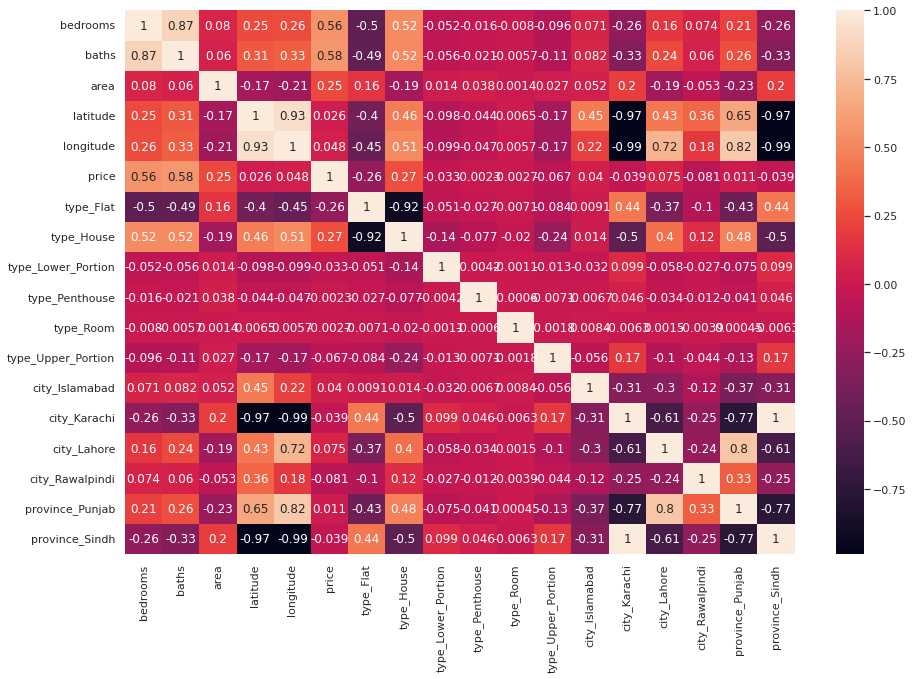

In [11]:
plt.figure(figsize=(15, 10))
sns.heatmap(housesClean.corr(), annot=True)
plt.show()

## Analysis

In [12]:
X = housesClean.drop(columns='price')
y = housesClean['price']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.2)

### Linear Regression Methods

In [13]:
print("Multiple Linear Regression")
linRegress = linMod.LinearRegression()
linRegress.fit(Xtrain, ytrain)

print("Linear R2:", r2_score(ytest, linRegress.predict(Xtest)))
print(linRegress.coef_)
print(linRegress.intercept_)

# PCA
pca = PCA(n_components=3)
XtrainPCA = pca.fit_transform(Xtrain)
XtestPCA = pca.fit_transform(Xtest)

# Polynomial Regression deg=2
print("Polynomial Regression deg=2")
poly = PolynomialFeatures(degree=2)
XtrainP = poly.fit_transform(XtrainPCA)
XtestP = poly.fit_transform(XtestPCA)
polyRegress = linMod.LinearRegression().fit(XtrainP, ytrain)

print("Quad R2:", r2_score(ytest, polyRegress.predict(XtestP)))
print(polyRegress.coef_)
print(polyRegress.intercept_)

Multiple Linear Regression
Linear R2: 0.41413937701830605
[ 2.68179078e+06  4.85936498e+06  2.55212254e+02 -2.39964300e+06
 -3.38976315e+04 -7.98693766e+06 -4.98159912e+06 -9.97291073e+06
 -7.74390941e+06 -4.83511529e+06 -1.08172471e+07  8.20809162e+06
 -4.11815649e+06  6.84177325e+06  5.44217384e+06 -4.08993513e+06
 -4.11815649e+06]
69215866.67174056
Polynomial Regression deg=2
Quad R2: 0.3837753247648519
[ 0.00000000e+00  4.41074630e+02  4.99498920e+05 -5.77827007e+06
 -1.82425268e-03  2.01696439e+01 -5.95014650e+00 -2.96958189e+04
  2.00398460e+05  7.85370366e+04]
21180167.57343653


### K Nearest Neighbors Regression Methods

K-Nearest R2: 0.8585392111390502
Best K value (Minkowski) is 5
Best R2 score (Minkowski) is 0.8585392111390502


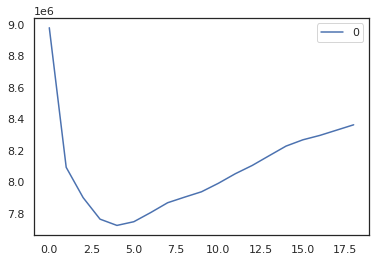

Best K value (Manhattan) is 5
Best R2 score (Manhattan) is 0.8597571170987081


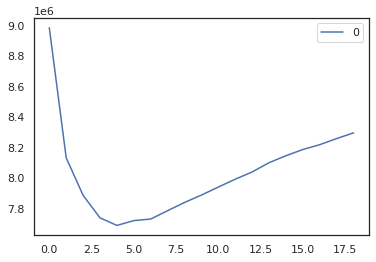

In [14]:
KNN = KNeighborsRegressor()
KNN.fit(Xtrain, ytrain)

print("K-Nearest R2:", r2_score(ytest, KNN.predict(Xtest)))

# Test different K values in K Nearest Neighbors

# Minkowski metric
rmse_val = []
BestK = 0
BestR2 = 0

for K in range(1, 20):
    KNN = KNeighborsRegressor(n_neighbors=K)
    KNN.fit(Xtrain, ytrain)
    error = np.sqrt(mean_squared_error(
        ytest, KNN.predict(Xtest)))  # calculate rmse
    rmse_val.append(error)  # store rmse values

    if r2_score(ytest, KNN.predict(Xtest)) > BestR2:  # Update best K value so far
        BestR2 = r2_score(ytest, KNN.predict(Xtest))
        BestK = K

print('Best K value (Minkowski) is', BestK)
print('Best R2 score (Minkowski) is', BestR2)

curve = pd.DataFrame(rmse_val)  # elbow curve
curve.plot()
plt.show()

# Manhattan metric
rmse_val = []
BestK = 0
BestR2 = 0

for K in range(1, 20):
    KNN = KNeighborsRegressor(n_neighbors=K, metric='manhattan')
    KNN.fit(Xtrain, ytrain)
    error = np.sqrt(mean_squared_error(
        ytest, KNN.predict(Xtest)))  # calculate rmse
    rmse_val.append(error)  # store rmse values

    if r2_score(ytest, KNN.predict(Xtest)) > BestR2:  # Update best K value so far
        BestR2 = r2_score(ytest, KNN.predict(Xtest))
        BestK = K

print('Best K value (Manhattan) is', BestK)
print('Best R2 score (Manhattan) is', BestR2)

curve = pd.DataFrame(rmse_val)  # elbow curve
curve.plot()
plt.show()

### Decision Tree Regression Methods

In [15]:
# Decision Tree Regression
treeRegress = DecisionTreeRegressor()
treeRegress.fit(Xtrain, ytrain)

print("Decision Tree R2:", r2_score(ytest, treeRegress.predict(Xtest)))

# Random Forest Regression
RFRegress = RandomForestRegressor()
RFRegress.fit(Xtrain, ytrain)

print("Random Forest R2:", r2_score(ytest, RFRegress.predict(Xtest)))

Decision Tree R2: 0.8688062630449658
Random Forest R2: 0.9021611664139612
